In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import scipy.signal
import hdf5storage
import librosa

from model import *
from tb_utils import *
from preprocessing import *

from scipy import io

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay

In [2]:
default_envelope_config = {
    'homomorphic_envelogram_with_hilbert': {'lpf_frequency': 8},
    'psd': {'fl_low': 40, 'fl_high': 60, 'resample': True},
    'wavelet': {'wavelet': 'db1',
                'levels': [4],
                'start_level': 1,
                'end_level': 5,
                'erase_pad': True}
}

In [3]:
recording_40840, frequency = librosa.load('./40840_TV.wav', sr=None)
pre_proc_data_40840_orig=renna_preprocess_wave(input_signal=recording_40840, fs=4000, config_dict=default_envelope_config)

"""
N=64
x_in = recording_40840
x_out = pre_proc_data_40840_orig

X_in = np.zeros((N*80))
X_out = np.zeros((4, N))

for k in range(0, len(x_in), N*80):
    if k + N*80 > len(x_in):
        # If the window is smaller than N, discard it
        continue
    
    else: 
        input = x_in[k:k+(N*80)]
        output = x_out[:, round(k/80):round(k/80)+N]

        X_in = np.vstack((X_in, input))
        X_out = np.dstack((X_out, output))  

X_in = X_in[1:,:]
X_out = X_out[:,:,1:]
"""

'\nN=64\nx_in = recording_40840\nx_out = pre_proc_data_40840_orig\n\nX_in = np.zeros((N*80))\nX_out = np.zeros((4, N))\n\nfor k in range(0, len(x_in), N*80):\n    if k + N*80 > len(x_in):\n        # If the window is smaller than N, discard it\n        continue\n    \n    else: \n        input = x_in[k:k+(N*80)]\n        output = x_out[:, round(k/80):round(k/80)+N]\n\n        X_in = np.vstack((X_in, input))\n        X_out = np.dstack((X_out, output))  \n\nX_in = X_in[1:,:]\nX_out = X_out[:,:,1:]\n'

In [4]:
model = get_model()
model.load_weights('parameters.h5')

In [13]:
tmp = np.reshape(X_out[:,:,:], (-1, 64, 4))
tmp= tf.convert_to_tensor(tmp, dtype=tf.float32)
output = model(tmp)
output = output.numpy()

output_argm = np.argmax(output, axis=-1) #should be +1
output_argm = output_argm.reshape(-1)

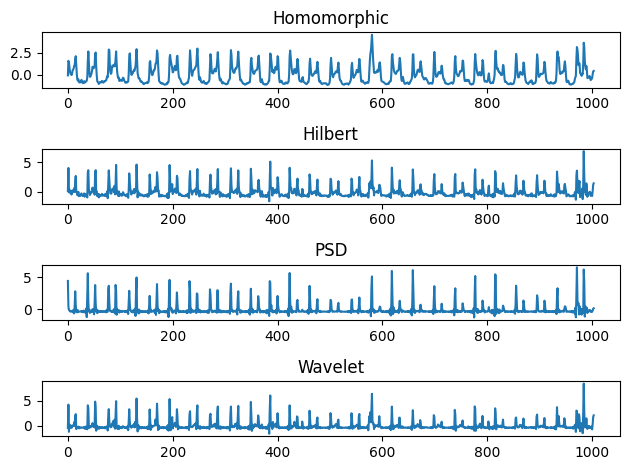

In [5]:
#recording_2530, frequency = librosa.load(r'C:\Users\domen\Desktop\eneriz_tb_gen\14241_PV.wav', sr=None)
#pre_proc_data_2530_orig=renna_preprocess_wave(input_signal=recording_2530, fs=4000, config_dict=default_envelope_config)
#X_out_2530_orig = patch_fun(recording_2530[1040:], pre_proc_data_2530_orig[:,13:])

plt.subplot(4,1,1)
plt.plot(pre_proc_data_40840_orig[0], label='Homomorphic')
plt.title('Homomorphic')
plt.subplot(4,1,2)
plt.plot(pre_proc_data_40840_orig[1], label='Hilbert')
plt.title('Hilbert')
plt.subplot(4,1,3)
plt.plot(pre_proc_data_40840_orig[2], label='PSD')
plt.title('PSD')
plt.subplot(4,1,4)
plt.plot(pre_proc_data_40840_orig[3], label='Wavelet')
plt.title('Wavelet')

plt.tight_layout()


In [5]:
swt_envelope_logic = hdf5storage.loadmat('./40840_data_Q16/swt_env_40840Q16.mat')
swt_envelope_logic = swt_envelope_logic['swt_env']
swt_envelope_logic = np.squeeze(swt_envelope_logic)

psd_envelope_logic = hdf5storage.loadmat('./40840_data_Q16/psd_env_40840Q16.mat')
psd_envelope_logic = psd_envelope_logic['psd_env']
psd_envelope_logic = np.squeeze(psd_envelope_logic)

homo_envelope_logic = hdf5storage.loadmat('./40840_data_Q16/homo_env_40840Q16.mat')
homo_envelope_logic = homo_envelope_logic['homo_env']
homo_envelope_logic = np.squeeze(homo_envelope_logic)

hilb_envelope_logic = hdf5storage.loadmat('./40840_data_Q16/hilb_env_40840Q16.mat')
hilb_envelope_logic = hilb_envelope_logic['hilb_env']
hilb_envelope_logic = np.squeeze(hilb_envelope_logic)

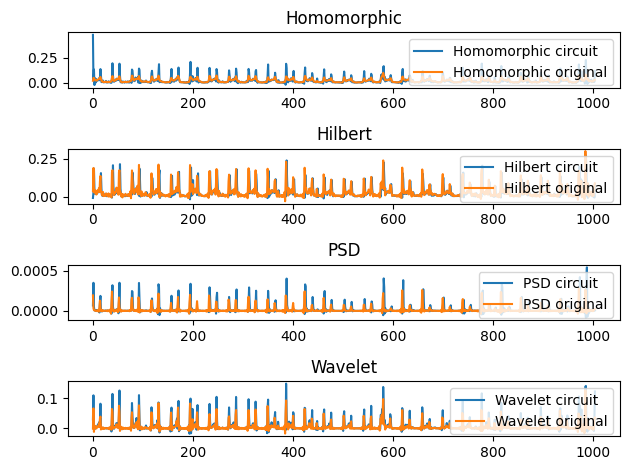

In [5]:
plt.subplot(4,1,1)
plt.plot(homo_envelope_logic[0:1004], label='Homomorphic circuit')
plt.plot(pre_proc_data_40840_orig[0], label='Homomorphic original')
plt.title('Homomorphic')
plt.legend(loc='upper right')
plt.subplot(4,1,2)
plt.plot(hilb_envelope_logic[0:1004], label='Hilbert circuit')
plt.plot(pre_proc_data_40840_orig[1], label='Hilbert original')
plt.title('Hilbert')
plt.legend(loc='upper right')
plt.subplot(4,1,3)
plt.plot(psd_envelope_logic[0:1004], label='PSD circuit')
plt.plot(pre_proc_data_40840_orig[2], label='PSD original')
plt.title('PSD')
plt.legend(loc='upper right')
plt.subplot(4,1,4)
plt.plot(swt_envelope_logic[0:1004], label='Wavelet circuit')
plt.plot(pre_proc_data_40840_orig[3], label='Wavelet original')
plt.title('Wavelet')
plt.legend(loc='upper right')
plt.tight_layout()

In [6]:
from scipy import stats, signal
from sklearn.metrics import mean_squared_error

print('swt',stats.pearsonr(pre_proc_data_40840_orig[3], swt_envelope_logic[0:1004]).statistic)
print('homo',stats.pearsonr(pre_proc_data_40840_orig[0], homo_envelope_logic[0:1004]).statistic)
print('hilb',stats.pearsonr(pre_proc_data_40840_orig[1], hilb_envelope_logic[1:1005]).statistic)
print('psd',stats.pearsonr(pre_proc_data_40840_orig[2], psd_envelope_logic[1:1005]).statistic)
print()
print('swt',mean_squared_error(pre_proc_data_40840_orig[3], swt_envelope_logic[0:1004]))
print('homo',mean_squared_error(pre_proc_data_40840_orig[0], homo_envelope_logic[0:1004]))
print('hilb',mean_squared_error(pre_proc_data_40840_orig[1], hilb_envelope_logic[1:1005]))
print('psd',mean_squared_error(pre_proc_data_40840_orig[2], psd_envelope_logic[1:1005]))

swt 0.814885663513073
homo 0.7286369630483516
hilb 0.907537021662348
psd 0.6576398573066148

swt 0.00016910769310357642
homo 0.0006929035810181212
hilb 0.0002940078514187291
psd 2.186819060007148e-09


In [8]:
swt = swt_envelope_logic[0:1004]
powersd = homo_envelope_logic[0:1004]
homo = hilb_envelope_logic[1:1005]
hilb = psd_envelope_logic[1:1005]


swt = (swt - swt.mean()) / swt.std()
powersd = (powersd - powersd.mean()) / powersd.std()
homo = (homo - homo.mean()) / homo.std()
hilb = (hilb - hilb.mean()) / hilb.std()

print(stats.pearsonr(pre_proc_data_40840_orig[3], swt).statistic)
print(stats.pearsonr(pre_proc_data_40840_orig[0], homo).statistic)
print(stats.pearsonr(pre_proc_data_40840_orig[1], hilb).statistic)
print(stats.pearsonr(pre_proc_data_40840_orig[2], powersd).statistic)
print()
print(mean_squared_error(pre_proc_data_40840_orig[3], swt))
print(mean_squared_error(pre_proc_data_40840_orig[0], homo))
print(mean_squared_error(pre_proc_data_40840_orig[1], hilb))
print(mean_squared_error(pre_proc_data_40840_orig[2], powersd))

0.8154021533776645
0.8131511304135428
0.5696279202462292
0.5745464528601276

0.9767574080827099
0.9730174777760379
0.9573160206104891
0.9999535723907114


In [6]:
#standardization
swt = swt_envelope_logic[0:1004]
homo = homo_envelope_logic[0:1004]
hilb = hilb_envelope_logic[1:1005]
psd = psd_envelope_logic[1:1005]

#swt = (swt - swt.mean()) / swt.std()
#homo = (homo - swt.mean()) / homo.std()
#hilb = (hilb - swt.mean()) / hilb.std()
#psd = (psd - psd.mean()) / psd.std()

#collection
envelopes = []
envelopes.append(homo)
envelopes.append(hilb)
envelopes.append(psd)
envelopes.append(swt)

x = np.stack(envelopes, axis=0)
x = (x - x.mean(axis=1, keepdims=True)) / x.std(axis=1, keepdims=True)

#np.save('40840_new_envelopsQ16',x)

"""
#patching
N=64
x_in = recording_40840
x_out = x

X_in = np.zeros((N*80))
X_out = np.zeros((4, N))

for k in range(0, len(x_in), N*80):
    if k + N*80 > len(x_in):
        # If the window is smaller than N, discard it
        continue
    
    else: 
        input = x_in[k:k+(N*80)]
        output = x_out[:, round(k/80):round(k/80)+N]

        X_in = np.vstack((X_in, input))
        X_out = np.dstack((X_out, output))  

X_in = X_in[1:,:]
X_out = X_out[:,:,1:]
"""

'\n#patching\nN=64\nx_in = recording_40840\nx_out = x\n\nX_in = np.zeros((N*80))\nX_out = np.zeros((4, N))\n\nfor k in range(0, len(x_in), N*80):\n    if k + N*80 > len(x_in):\n        # If the window is smaller than N, discard it\n        continue\n    \n    else: \n        input = x_in[k:k+(N*80)]\n        output = x_out[:, round(k/80):round(k/80)+N]\n\n        X_in = np.vstack((X_in, input))\n        X_out = np.dstack((X_out, output))  \n\nX_in = X_in[1:,:]\nX_out = X_out[:,:,1:]\n'

In [16]:
tmp = np.reshape(X_out[:,:,:], (-1, 64, 4))
tmp= tf.convert_to_tensor(tmp, dtype=tf.float32)
output = model(tmp)
output = output.numpy()

output_argm_new = np.argmax(output, axis=-1) #should be +1
output_argm_new = output_argm_new.reshape(-1)

Confusion matrix, without normalization
[[ 43  23  14  39]
 [ 23 103  31  91]
 [  4  13  39  51]
 [ 57  46  51 332]]
Normalized confusion matrix
[[0.36134454 0.19327731 0.11764706 0.32773109]
 [0.09274194 0.41532258 0.125      0.36693548]
 [0.03738318 0.12149533 0.36448598 0.47663551]
 [0.11728395 0.09465021 0.10493827 0.68312757]]


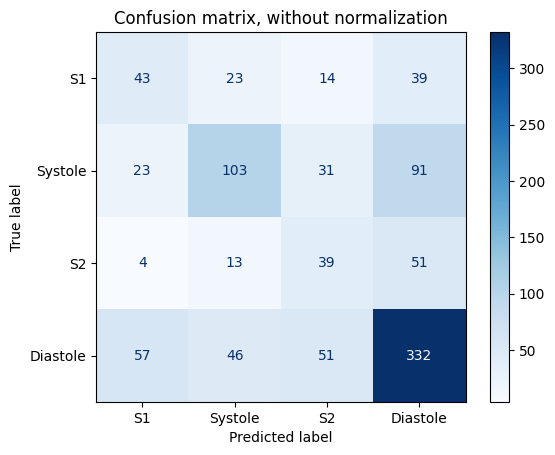

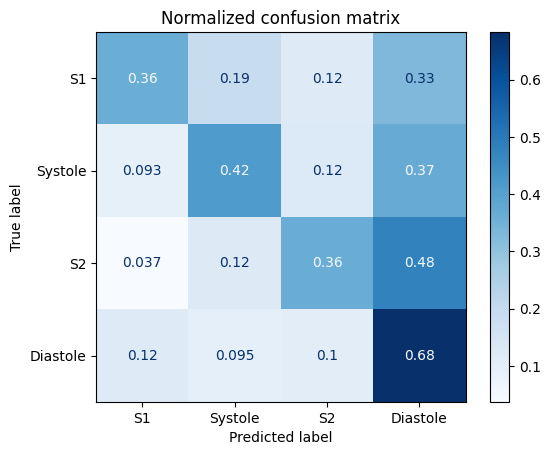

In [18]:
acc_value = accuracy_score(output_argm, output_argm_new, normalize=True)

matrix = confusion_matrix(output_argm, output_argm_new)
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        output_argm,
        output_argm_new,
        display_labels=['S1', 'Systole', 'S2', 'Diastole'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix, without normalization
[[119   0   0   0]
 [  0 248   0   0]
 [  0   0 107   0]
 [  0   0   0 486]]
Normalized confusion matrix
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


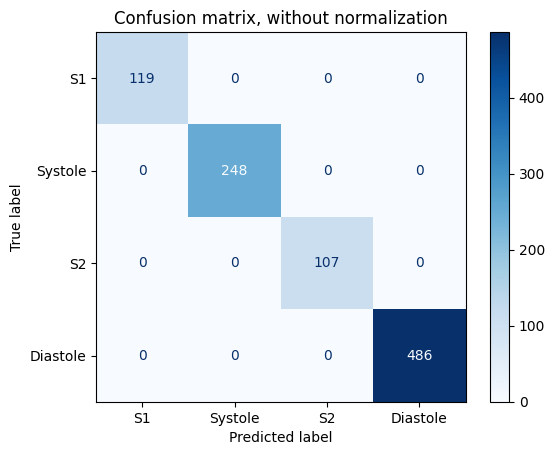

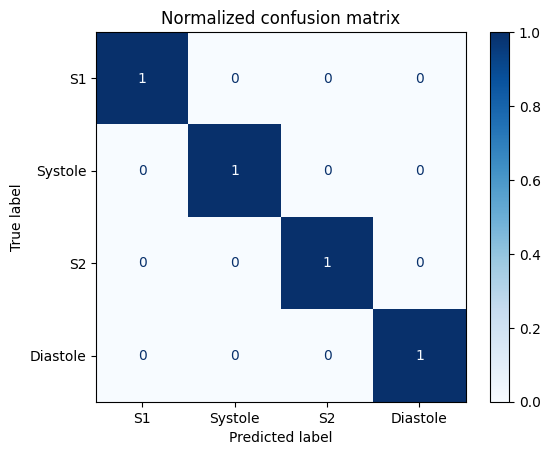

In [9]:
antonio_cnn_out = np.load('40840_AV_cnn_output.npy')
antonio_cnn_out = np.argmax(antonio_cnn_out, axis=-1) #should be +1
antonio_cnn_out = antonio_cnn_out.reshape(-1)

acc_value = accuracy_score(antonio_cnn_out, output_argm_new, normalize=True)

matrix = confusion_matrix(antonio_cnn_out, output_argm_new)
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        output_argm,
        output_argm_new,
        display_labels=['S1', 'Systole', 'S2', 'Diastole'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

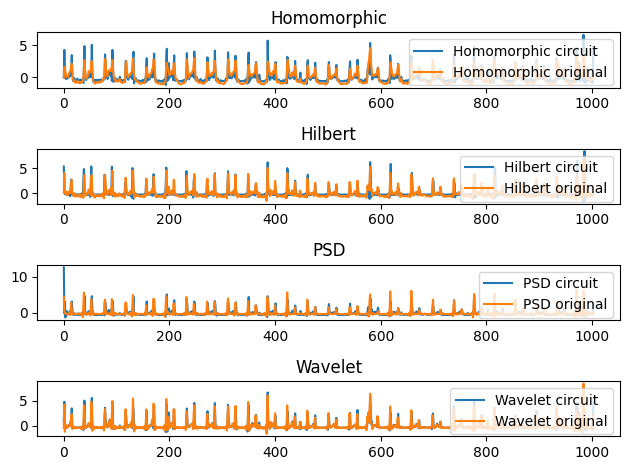

In [12]:
plt.subplot(4,1,1)
plt.plot(homo, label='Homomorphic circuit')
plt.plot(pre_proc_data_40840_orig[0], label='Homomorphic original')
plt.title('Homomorphic')
plt.legend(loc='upper right')
plt.subplot(4,1,2)
plt.plot(hilb, label='Hilbert circuit')
plt.plot(pre_proc_data_40840_orig[1], label='Hilbert original')
plt.title('Hilbert')
plt.legend(loc='upper right')
plt.subplot(4,1,3)
plt.plot(powersd, label='PSD circuit')
plt.plot(pre_proc_data_40840_orig[2], label='PSD original')
plt.title('PSD')
plt.legend(loc='upper right')
plt.subplot(4,1,4)
plt.plot(swt, label='Wavelet circuit')
plt.plot(pre_proc_data_40840_orig[3], label='Wavelet original')
plt.title('Wavelet')
plt.legend(loc='upper right')
plt.tight_layout()

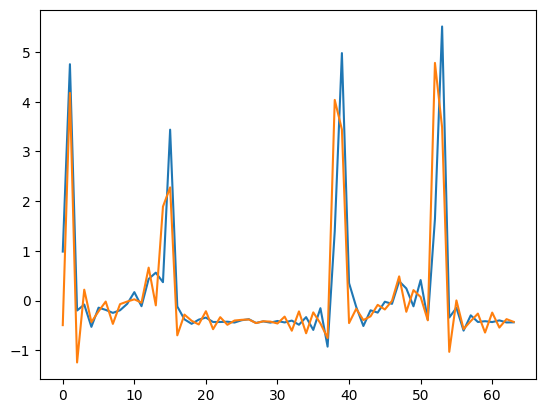

In [14]:
plt.plot(swt[0:64], label='Wavelet circuit')
plt.plot(pre_proc_data_40840_orig[3][0:64], label='Wavelet original')

C:\Users\domen\AppData\Local\Temp\ipykernel_48412\1479728223.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


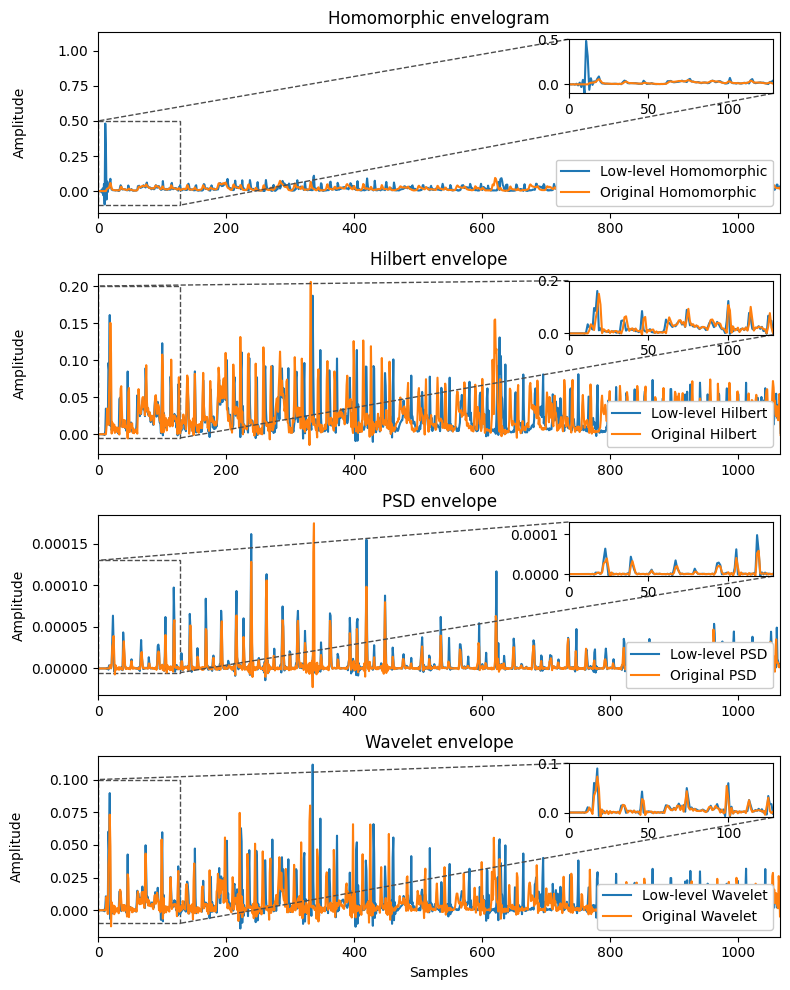

In [113]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 10))
homo_orig = pre_proc_data_40840_orig[0]
hilb_orig = pre_proc_data_40840_orig[1]
psd_orig = pre_proc_data_40840_orig[2]
swt_orig = pre_proc_data_40840_orig[3]

# Plot data in each subplot
axs[0].plot(homo_envelope_logic[:1180], label='Low-level Homomorphic')
axs[0].plot(homo_orig, label='Original Homomorphic')
axs[0].set_title('Homomorphic envelogram')
axs[0].legend(loc='lower right',framealpha=1)
axs[0].set_ylabel('Amplitude', labelpad=22)
axs[0].set_xlim(0, 1065)

ax_indicate_0 = inset_axes(axs[0], width="30%", height="30%", loc='upper right')
ax_indicate_0.plot(axs[0].lines[0].get_xdata(), axs[0].lines[0].get_ydata())
ax_indicate_0.plot(axs[0].lines[1].get_xdata(), axs[0].lines[1].get_ydata())
ax_indicate_0.set_xlim(0, 128)  # Adjust the limits according to your data
ax_indicate_0.set_ylim(-0.1, 0.5)  # Adjust the limits according to your data
mark_inset(axs[0], ax_indicate_0, loc1=2, loc2=4, fc="none", ec="0.3", ls='--')


axs[1].plot(hilb_envelope_logic, label='Low-level Hilbert')
axs[1].plot(np.pad(hilb_orig, [(13, 0)], mode='constant', constant_values=0), label='Original Hilbert')
axs[1].set_title('Hilbert envelope')
axs[1].legend(loc='lower right',framealpha=1)
axs[1].set_ylabel('Amplitude', labelpad=22)
axs[1].set_xlim(0, 1065)

ax_indicate_1 = inset_axes(axs[1], width="30%", height="30%", loc='upper right')
ax_indicate_1.plot(axs[1].lines[0].get_xdata(), axs[1].lines[0].get_ydata())
ax_indicate_1.plot(axs[1].lines[1].get_xdata(), axs[1].lines[1].get_ydata())
ax_indicate_1.set_xlim(0, 128)  # Adjust the limits according to your data
ax_indicate_1.set_ylim(-0.005, 0.2)  # Adjust the limits according to your data
mark_inset(axs[1], ax_indicate_1, loc1=2, loc2=4, fc="none", ec="0.3", ls='--')

axs[2].plot(psd_envelope_logic, label='Low-level PSD')
axs[2].plot(np.pad(psd_orig, [(18, 0)], mode='constant', constant_values=0), label='Original PSD')
axs[2].set_title('PSD envelope')
axs[2].legend(loc='lower right',framealpha=1)
axs[2].set_ylabel('Amplitude')
axs[2].set_xlim(0, 1065)

ax_indicate = inset_axes(axs[2], width="30%", height="30%", loc='upper right')
ax_indicate.plot(axs[2].lines[0].get_xdata(), axs[2].lines[0].get_ydata())
ax_indicate.plot(axs[2].lines[1].get_xdata(), axs[2].lines[1].get_ydata())
ax_indicate.set_xlim(0, 128)  # Adjust the limits according to your data
ax_indicate.set_ylim(-0.000005, 0.00013)  # Adjust the limits according to your data
mark_inset(axs[2], ax_indicate, loc1=2, loc2=4, fc="none", ec="0.3", ls='--')

axs[3].plot(swt_envelope_logic, label='Low-level Wavelet')
axs[3].plot(np.pad(swt_orig, [(12, 0)], mode='constant', constant_values=0), label='Original Wavelet')
axs[3].set_title('Wavelet envelope')
axs[3].set_ylabel('Amplitude', labelpad=18)
axs[3].legend(loc='lower right',framealpha=1)
axs[3].set_xlabel('Samples')
axs[3].set_xlim(0, 1065)

ax_indicate = inset_axes(axs[3], width="30%", height="30%", loc='upper right')
ax_indicate.plot(axs[3].lines[0].get_xdata(), axs[3].lines[0].get_ydata())
ax_indicate.plot(axs[3].lines[1].get_xdata(), axs[3].lines[1].get_ydata())
ax_indicate.set_xlim(0, 128)  # Adjust the limits according to your data
ax_indicate.set_ylim(-0.01, 0.1)  # Adjust the limits according to your data
mark_inset(axs[3], ax_indicate, loc1=2, loc2=4, fc="none", ec="0.3", ls='--')

plt.tight_layout()
plt.savefig('envelopes_2530_iir.svg')
plt.show()

In [7]:
with open("40840_TV.tsv", 'r') as f:
    data = f.read()

data = data.split('\n')

input_data = np.empty((len(data)-1, 3), dtype=float)  # Creazione di un array vuoto con le dimensioni corrette

for i in range(len(data)-1):
    row_values = data[i].split('\t')
    for j in range(len(row_values)):
        input_data[i, j] = float(row_values[j])

# Find the duration in seconds of the recording (last value of the second column)
T = input_data[-1,1]

# Generate a time array with 50 Hz sampling rate
t = np.arange(0, T, 1.0/50.0)

# Generate the s array
s = np.zeros_like(t)

# For each time instant, find its heart state and assign it to the s array
for i in range(len(t)):
    # Find the first value greater than t(i)
    j = np.argmax(input_data[:,1] > t[i])
    # Assign the heart state to s(i)
    s[i] = input_data[j,2]

In [8]:
N=64
tau=8

X = np.zeros((0, 4, N))
S = np.zeros((0, N))

# Get envelopes
x_global = x
s_global = s


# Extract the indexes of the s elements with heart state information
labeled_idxs_global = np.where(s_global!=0)[0]

# Find 0 intervals between heart state changes
zero_intervals = np.diff(labeled_idxs_global)-1 != 0

# Split x and s between those intervals
x_split = np.split(x_global, labeled_idxs_global[1:][zero_intervals], axis=1)
s_split = np.split(s_global, labeled_idxs_global[1:][zero_intervals])

for k in range(len(x_split)):

    # Extract the indexes of the s elements with heart state information
    labeled_idxs = np.where(s_split[k]!=0)[0]

    # Use only data with heart state information
    x = x_split[k][:, labeled_idxs]
    s = s_split[k][labeled_idxs]
    
    if x.shape[1] < N:
        # If the window is smaller than N, discard it
        continue

    x = rolling_strided_window(x, N, tau)
    s = rolling_strided_window(s, N, tau)

    x, s = check_valid_sequence(x, s, 1)

    # Stack the windows
    X = np.vstack((X, x))
    S = np.vstack((S, s))
        
    # Create a new axis in S and concatenate X and S
    S = S[:, np.newaxis, :]
    XS = np.concatenate((X, S), axis=1)

    # Shuffle the samples
    #np.random.shuffle(XS)

    # Return the X and S arrays
    X = XS[:, :x.shape[1], :]
    S = XS[:, x.shape[1]:, :]

    # Swap axes to format the data as channels_last
    X = np.swapaxes(X, 1, 2)
    S = np.swapaxes(S, 1, 2)

    # Transform S to categorical
    S = to_categorical(S-1)

In [10]:
def unroll_strided_windows(S: np.ndarray, tau: int) -> np.ndarray:
    """Unrolls the input `S` 3D array with shape (n_windows, N, 4), which is
    supposed to be generated with stride `tau`, outputing a 2D vector. The
    elements in the overlapping positions are averaged.

    Args:
    -----
        S (np.ndarray): Input 3D array.
        tau (int): Stride of the input array.

    Returns:
    --------
        s (np.ndarray): 2D array with shape (tau*(n_windows-1) + N, 4).
    """
    
    # Check that the input array is a np.ndarray
    if not isinstance(S, np.ndarray):
        raise TypeError('Input array must be a np.ndarray')
    
    # Check that the input array is 2D
    if S.ndim != 3:
        raise ValueError('Input array must be 3D.')

    # Check that the stride is positive integer
    if not isinstance(tau, int):
        raise TypeError('Stride must be an integer.')

    # Obtain the window size and the number of windows
    N = S.shape[1]
    n_windows = S.shape[0]

    # Calculate the length of the output array
    s_len = tau*(n_windows-1) + N

    # Create a 2D array of NaNs of size (n_windows, s_len)
    s_expanded = np.full((n_windows, s_len, 4), np.nan)

    # Allocate each window to the corresponding position in the expanded array
    for i in range(n_windows):
        s_expanded[i, tau*i:tau*i+N, :] = S[i, :, :]
    
    # Calculate the mean of the expanded array in the first axis
    s = np.nanmean(s_expanded, axis=0)

    return np.squeeze(s)

In [9]:
output = model.predict(X)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [11]:
s_pred = unroll_strided_windows(output, tau)
s_true = unroll_strided_windows(S, tau)

s_pred = np.squeeze(s_pred.argmax(axis=-1)+1)
s_true = np.squeeze(s_true.argmax(axis=-1)+1)

In [14]:
def seq_max_temporal_model(x: np.ndarray) -> np.ndarray:
    """Implementation of the sequential max temporal modeling. It forces the input
    states sequence to contain only admisible transitions among heart states
    (S1->systolic->S2->diastolic->S1).

    Args:
    -----
        x (np.ndarray): Input sequence of states. The elements must be integers
        between 1 and 4.

    Returns:
    --------
        y (np.ndarray): Output sequence of states, where only admisible
        transitions are present.
    """

    # Check if x is a numpy array of 1D
    if not isinstance(x, np.ndarray) or x.ndim != 1:
        raise TypeError('x must be a numpy array of 1D.')
    
    # Create y as an empty array of same size as x
    y = np.zeros(x.shape)

    # Set that the first element of y is the same as the first element of x
    y[0] = x[0]

    # Iterate over the rest of the elements of x
    for i in range(1, x.shape[0]):
        # If x[i] = (x[i-1] + 1) % 4, then y[i] = x[i]
        if y[i-1] % 4 + 1 == x[i]:
            y[i] = x[i]
        # Otherwise, y[i] = y[i-1]
        else:
            y[i] = y[i-1]
    
    return y

In [15]:
s_pred_sqtm = seq_max_temporal_model(s_pred)

In [16]:
acc_value = accuracy_score(s_true, s_pred_sqtm, normalize=True)
print(acc_value)

matrix = confusion_matrix(s_true, s_pred_sqtm)
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

print(matrix)
print(per_class_accuracy)

0.9
[[148  21   0  12]
 [  2 126   0   0]
 [  0  44 129   1]
 [  3   0  13 461]]
[0.81767956 0.984375   0.74137931 0.96645702]


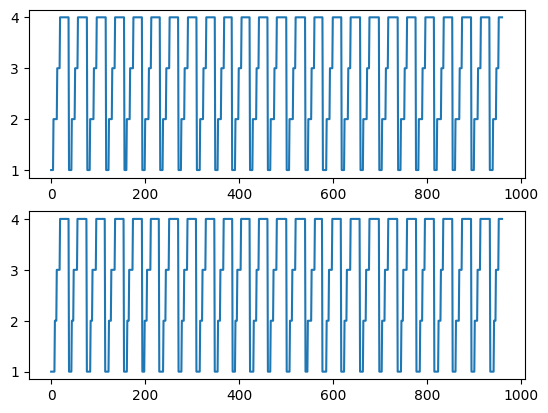

In [13]:
plt.subplot(2,1,1)
plt.plot(s_pred)
plt.subplot(2,1,2)
plt.plot(s_true)